In [21]:
import sys
if not '/home/pop518504/git/gknet-benchmarks' in sys.path:
    sys.path.insert(0, '/home/pop518504/git/gknet-benchmarks')
    
from utils import *
from jax_utils import * 
import seaborn as sns
sns.set_style("darkgrid")

super_cells = load_super_cells_from_pickle("/home/pop518504/git/gknet-benchmarks/make_supercells/supercells_108_23328.pickle")
# results = load_results_from_pickle("results/100_runs/results_100_runs.pickle")
# oom_events: List[Tuple[Callable, Calculator, str]] = load_oom_events_from_pickle("oom_events.pickle")

ase = load_results_from_pickle("pickles/ase/ase_nl_runtime.pickle")
jaxmd_pair = load_results_from_pickle("pickles/jaxmd-pair/jaxmd_pair_runtime.pickle")
jaxmd_nl = load_results_from_pickle("pickles/jaxmd-nl/jaxmd_nl_runtime.pickle")
jaxmd_gnn = load_results_from_pickle("pickles/jaxmd-gnn/jaxmd_gnn_runtime.pickle")

results = ase + jaxmd_pair + jaxmd_nl + jaxmd_gnn

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/ase/ase_nl_runtime.pickle'

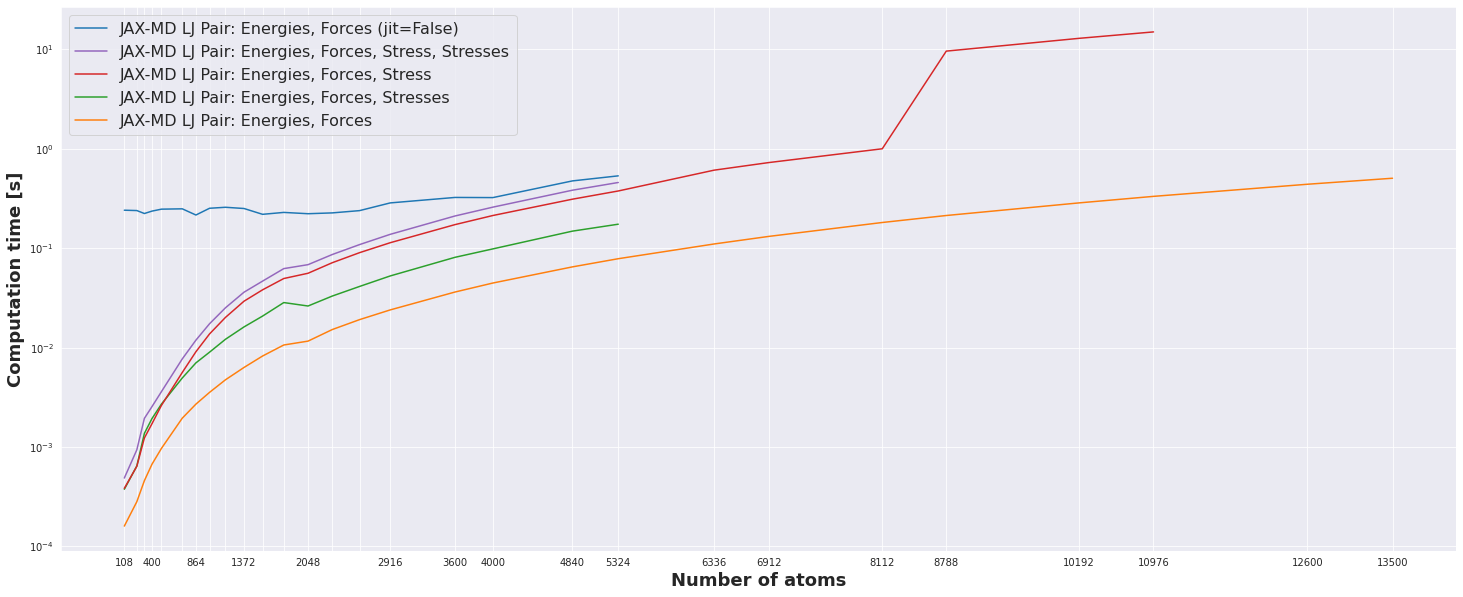

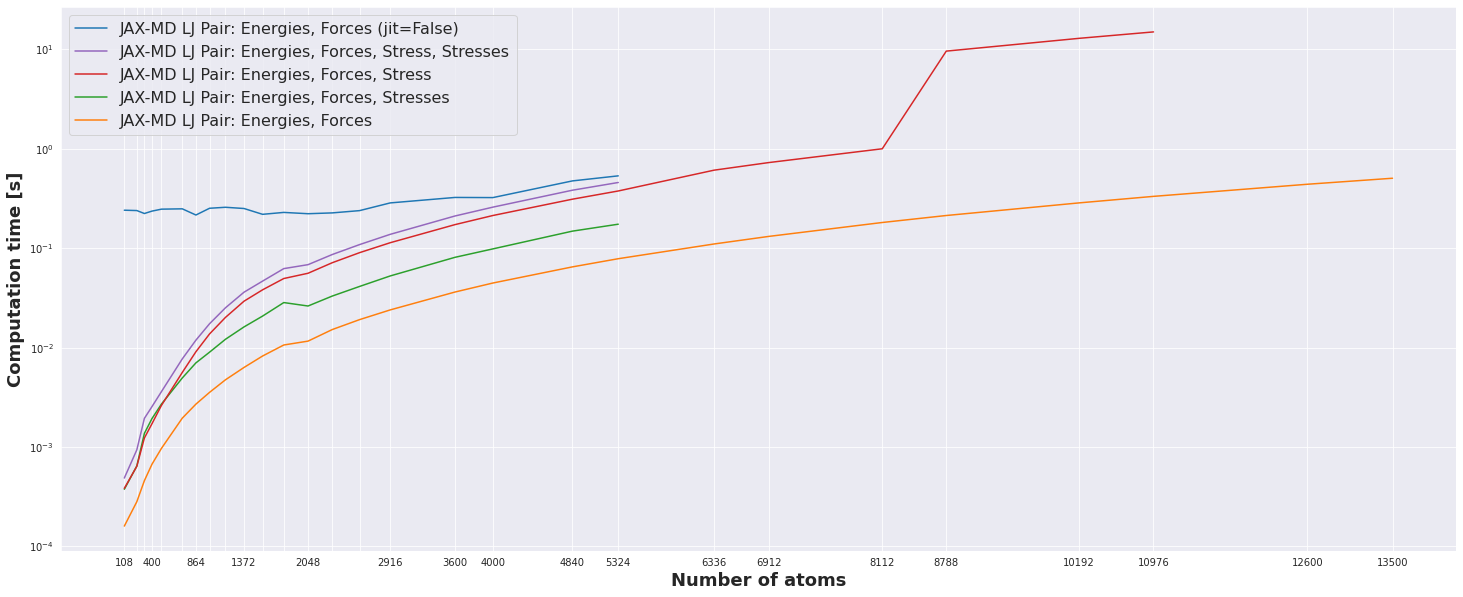

In [20]:
fig, ax = plot_runtimes(results=jaxmd_pair, figsize=(25, 10))

handles, labels = ax.get_legend_handles_labels()

new_handles = [None, None, None, None, None]
new_labels = [None, None, None, None, None]

# energies, forces, jit=False
new_handles[0] = handles[0]
new_labels[0] = labels[0]

# energies, forces, stress, stresses
new_handles[1] = handles[4]
new_labels[1] = labels[4]

# energies, forces, stress
new_handles[2] = handles[3]
new_labels[2] = labels[3]

# energies, forces, stresses
new_handles[3] = handles[2]
new_labels[3] = labels[2]

# energies, forces
new_handles[4] = handles[1]
new_labels[4] = labels[1]

ax.legend(new_handles, new_labels, prop={'size': 16})
fig

In [30]:
for _, events_per_calculator in group_by(oom_events, lambda e: e[1].description):
    events_per_calculator = list(events_per_calculator)
    calc_description = events_per_calculator[0][1].description
    
    print(calc_description)
    
    for e in events_per_calculator:
        callable, calc, reason = e
        # print(calc._oom_runs)  
        print("OOM during {} at n = {} (stress={}, stresses={}, jit={}). oom_runs={}".format(reason, calc.n, calc._stress, calc._stresses, calc._jit, calc._oom_runs))

    print() 

JAX-MD Pair (stress=True, stresses=True, jit=True)
OOM during Warm-up at n = 6336 (stress=True, stresses=True, jit=True). oom_runs=[]



In [2]:
system_sizes = [len(atoms) for atoms in super_cells]            
_, oom_calculators = load_calculators_from_pickle("/home/pop518504/git/gknet-benchmarks/benchmarks/oom_analysis/oom_analysis.pickle")
print_oom_behavior_runtime_vs_dedicated(system_sizes, results, oom_calculators)

GNN Neighbor List (stress=False, stresses=False, jit=False)            OOM at n=3600,3600 (runtime, dedicated)
GNN Neighbor List (stress=False, stresses=False, jit=True)             OOM at n=5324,5324 (runtime, dedicated)
GNN Neighbor List (stress=False, stresses=True, jit=True)              OOM at n=1568,2916 (runtime, dedicated)
GNN Neighbor List (stress=True, stresses=False, jit=True)              OOM at n=2916,3600 (runtime, dedicated)
GNN Neighbor List (stress=True, stresses=True, jit=True)               OOM at n=1568,2916 (runtime, dedicated)
JAX-MD Neighbor List (stress=False, stresses=False, jit=False)         OOM at n=10976,13500 (runtime, dedicated)
JAX-MD Neighbor List (stress=False, stresses=False, jit=True)          OOM at n=10976,13500 (runtime, dedicated)
JAX-MD Neighbor List (stress=False, stresses=True, jit=True)           OOM at n=10976,13500 (runtime, dedicated)
JAX-MD Neighbor List (stress=True, stresses=False, jit=True)           OOM at n=10976,13500 (runtime, dedi

# All calculators by equal property set
## All properties: `stress=True`, `stresses=True`

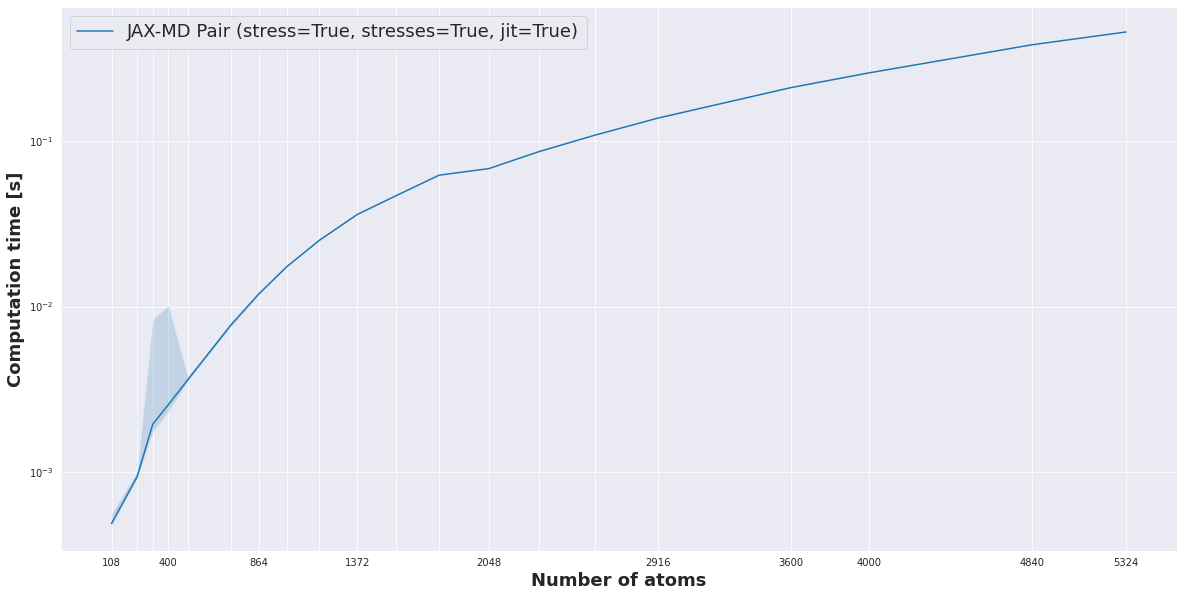

In [16]:
stress_and_stresses = list(filter(lambda r: "ASE" in r.calculator.description or r.calculator._stress and r.calculator._stresses, results))

plot_runtimes(results=stress_and_stresses,
              shade_by='minmax')
#              figsize=(50, 10))

## Only stress: `stress=True`, `stresses=False`

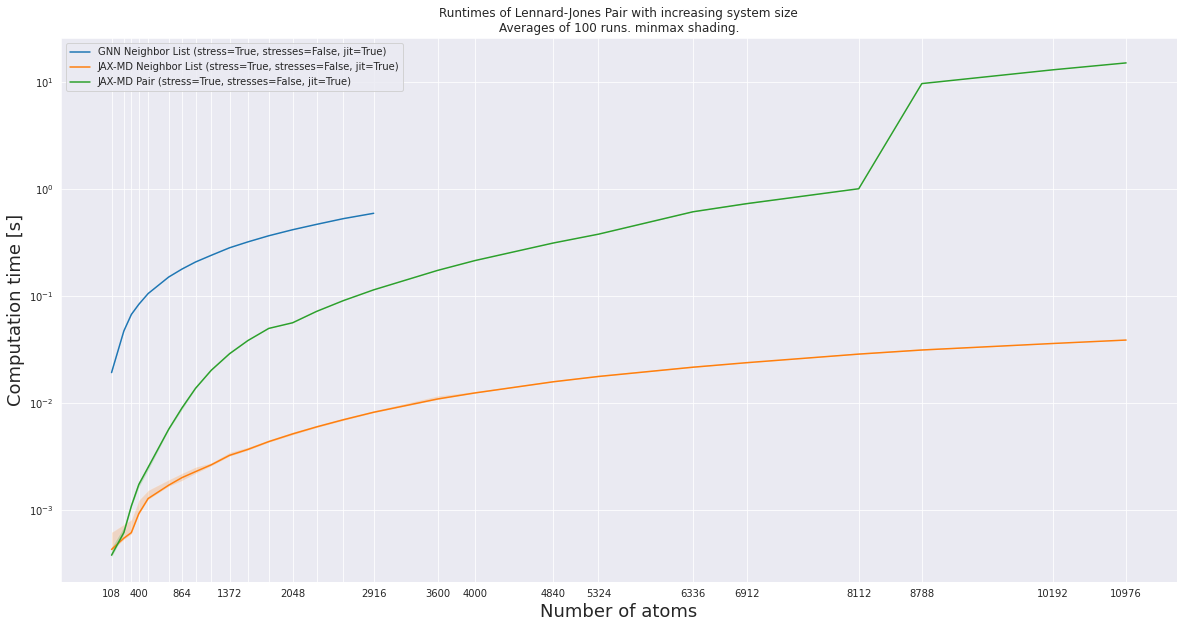

In [16]:
only_stress = list(filter(lambda r: "ASE" not in r.calculator.description and r.calculator._stress and r.calculator._stresses == False, results))

plot_runtimes(results=only_stress, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size',
              shade_by='minmax')
#              figsize=(50, 10))

## Only stresses: `stress=False`, `stresses=True`

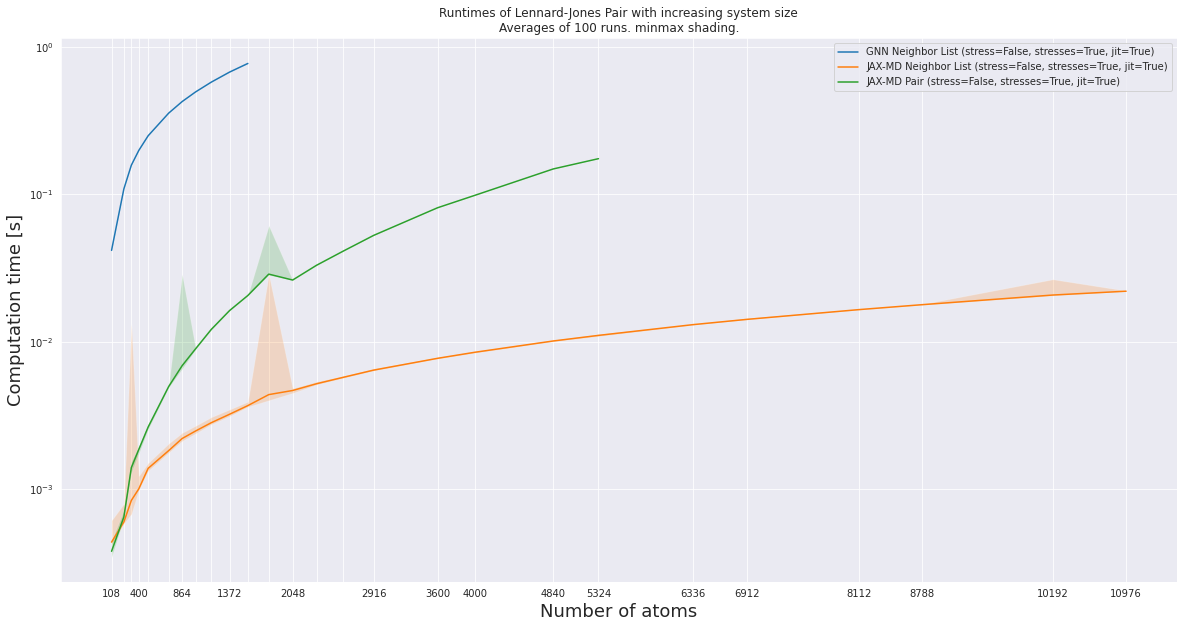

In [17]:
only_stresses = list(filter(lambda r: "ASE" not in r.calculator.description and r.calculator._stress == False and r.calculator._stresses, results))

plot_runtimes(results=only_stresses, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size',
              shade_by='minmax')
#              figsize=(50, 10))

## No stress(es): `stress=False, stresses=False`
### `jit=True` to prevent overplotting

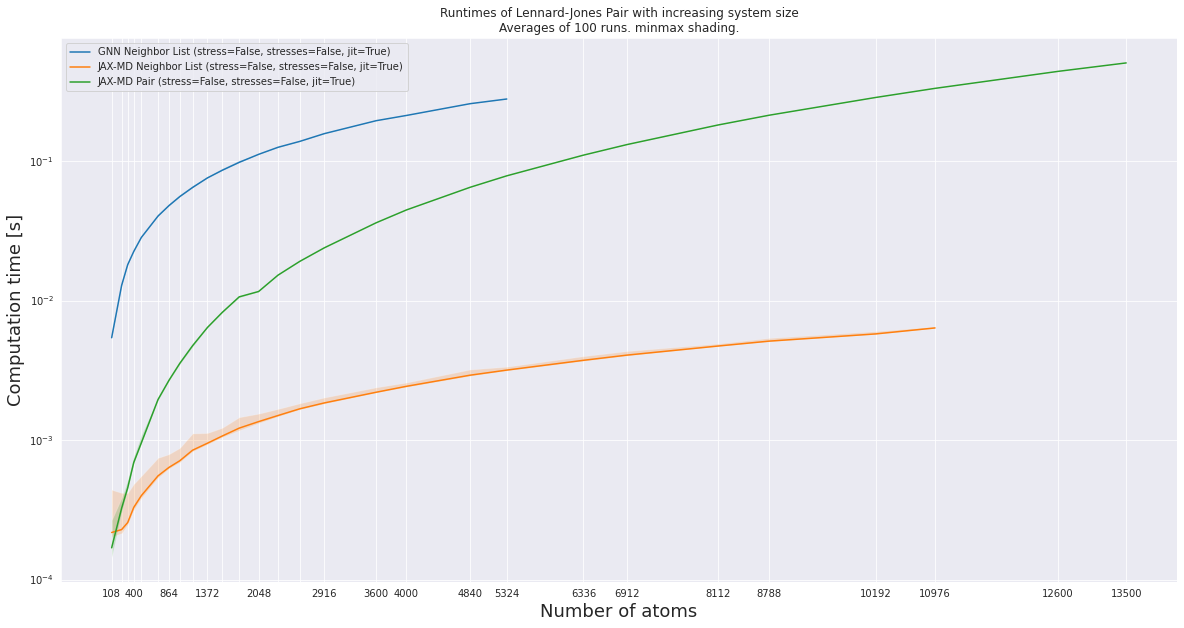

In [20]:
no_stresses = list(filter(lambda r: "ASE" not in r.calculator.description and r.calculator._stress == False and r.calculator._stresses == False, results))
no_stresses = list(filter(lambda r: r.calculator._jit, no_stresses))

plot_runtimes(results=no_stresses, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size',
              shade_by='minmax')
#              figsize=(50, 10))

### `jit=False` to show extreme variance due to constant compilation cost

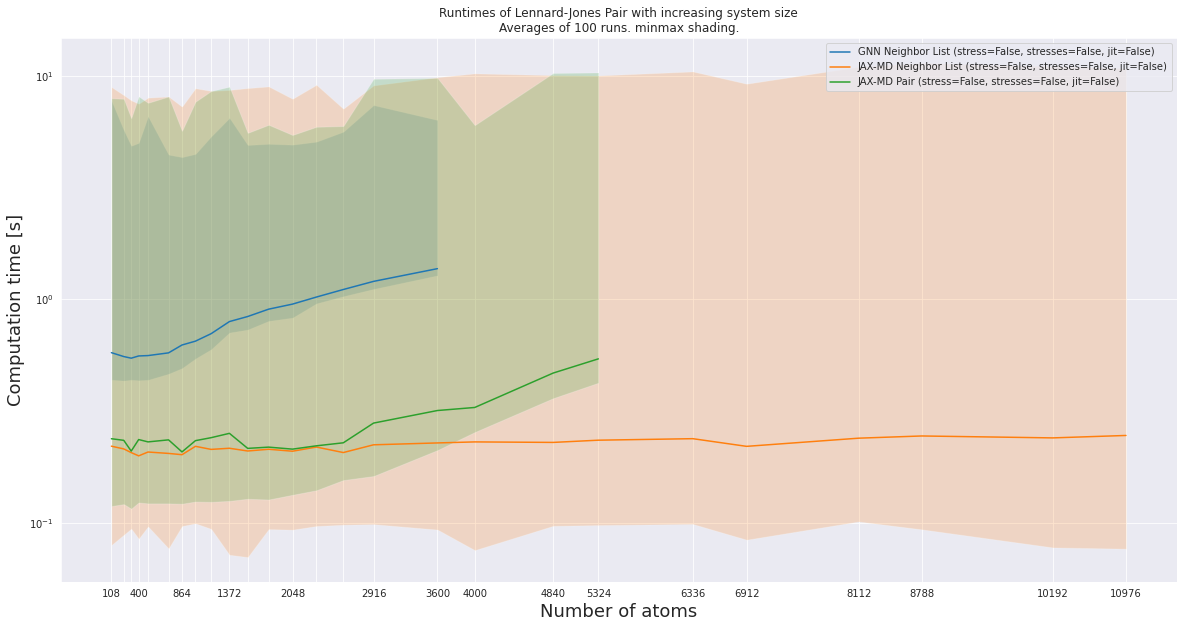

In [24]:
no_stresses_nojit = list(filter(lambda r: "ASE" not in r.calculator.description and r.calculator._stress == False and r.calculator._stresses == False and r.calculator._jit == False, results))

plot_runtimes(results=no_stresses_nojit, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size',
              shade_by='minmax')
#              figsize=(50, 10))

# Only slow calculators
i.e. ASE and JAX-MD with `jit=False`.

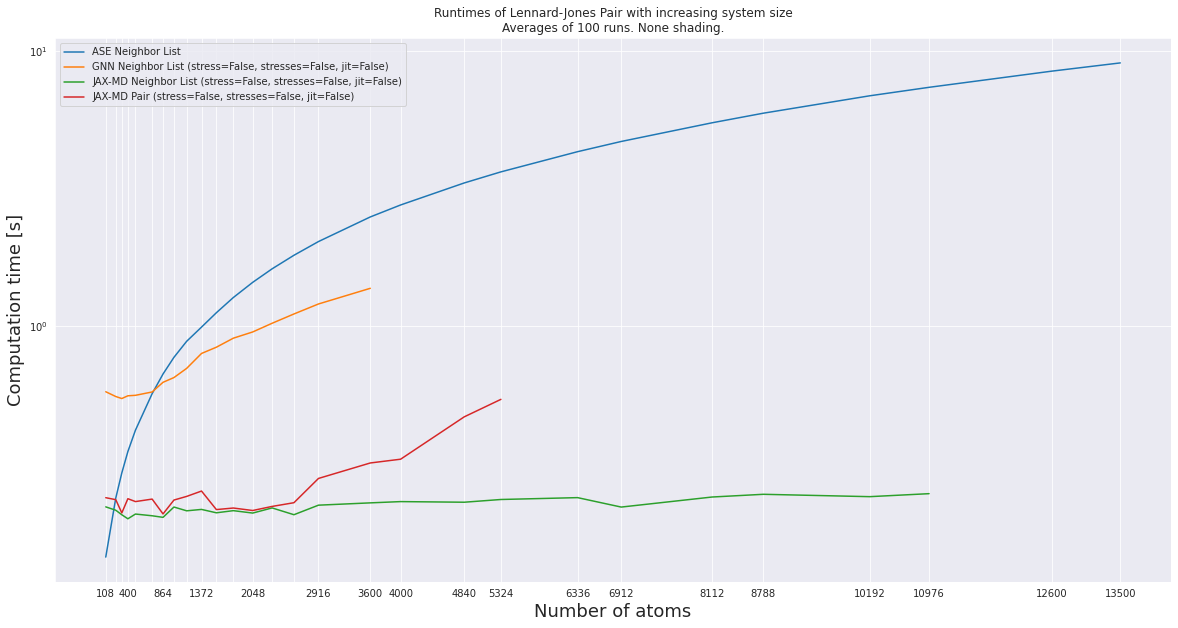

In [25]:
slow_results = list(filter(lambda r: "jit=True" not in r.calculator.description, results))

plot_runtimes(results=slow_results, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size')

# do this with more than 2048 atoms
# maybe without ASE intialization, smoother system size increase

# for same with neighbor lists, maybe initialize w/ FHI-Vibes

## Only fast calculators

i.e. JAX-MD with `jit=True`.

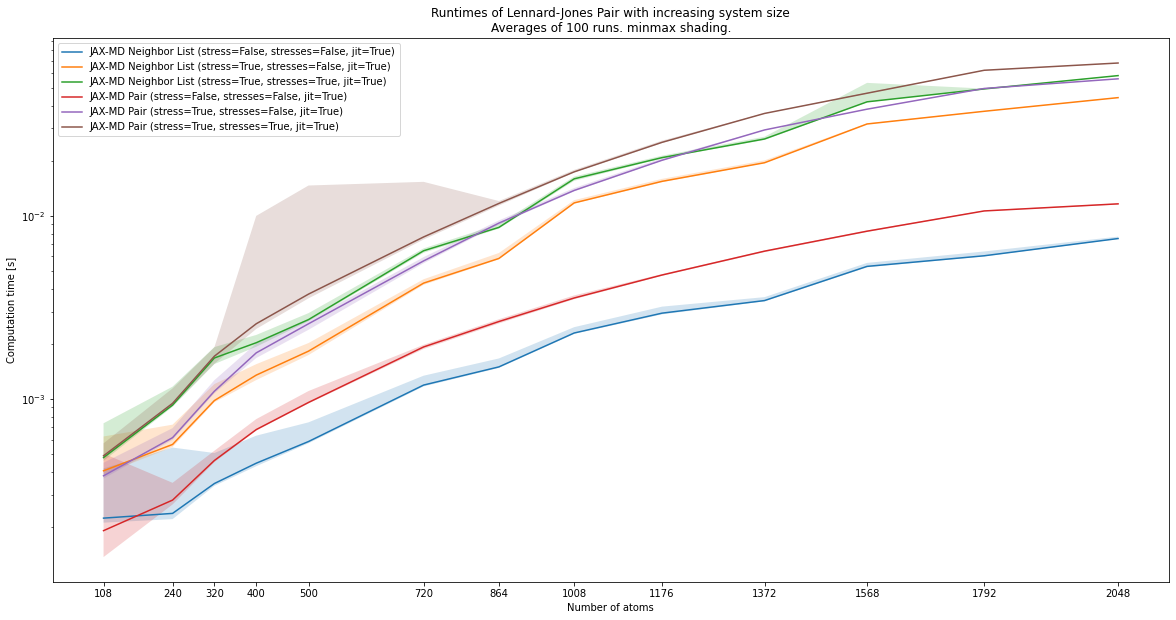

In [14]:
fast_results = list(filter(lambda r: "jit=False" not in r.calculator.description, results))
fast_results = list(filter(lambda r: "ASE" not in r.calculator.description, fast_results))

plot_runtimes(results=fast_results, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size', 
              shade_by='minmax')

## `JAX-MD`: Pair vs. Neighbor Lists

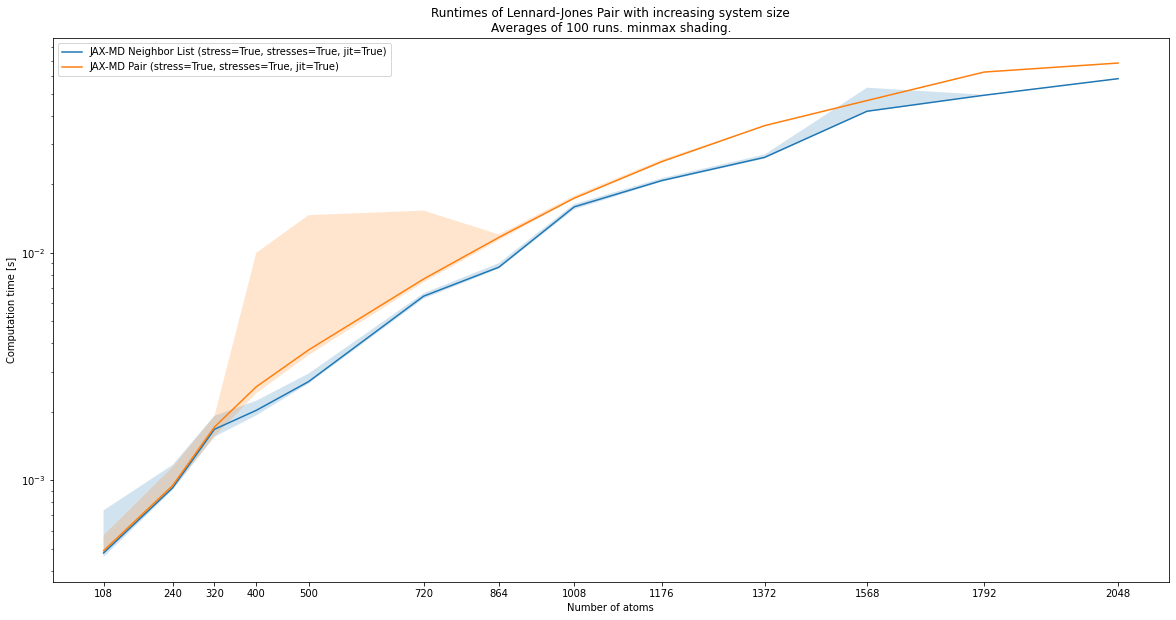

In [19]:
filtered_results = list(filter(lambda r: "jit=True" in r.calculator.description, results))
filtered_results = list(filter(lambda r: "stress=True" in r.calculator.description, filtered_results))
filtered_results = list(filter(lambda r: "stresses=True" in r.calculator.description, filtered_results))

plot_runtimes(results=filtered_results, 
              plot_title='Runtimes of Lennard-Jones Pair with increasing system size', 
              shade_by='minmax')

## Runtime per system size
(Same calculator as previous plot)

- For a single calculator: Per system size, plot the runtime over its indices.
- We perform the same computation repeatedly, so runtime should be pretty constant.
- Caching mechanisms would likely cause a consistent drop after initial computations.

### Pair

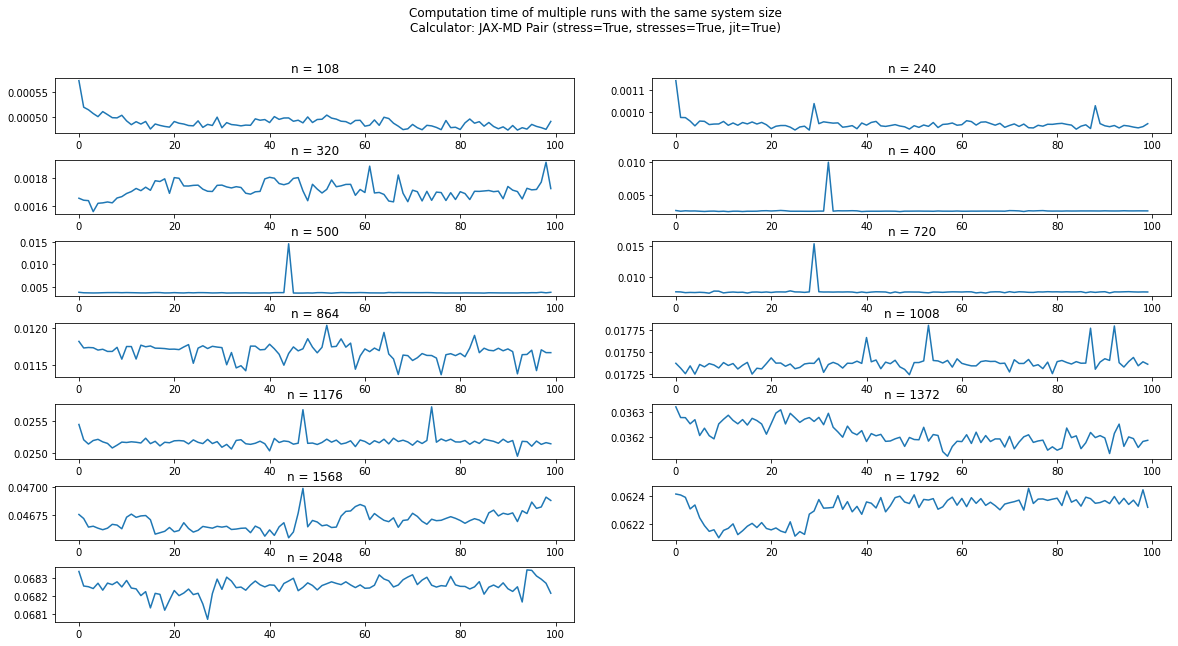

In [20]:
single_calculator = filter(lambda r: "JAX-MD Pair (stress=True, stresses=True, jit=True" in r.calculator.description, results)
plot_runtime_variances(list(single_calculator))

### Neighbor List

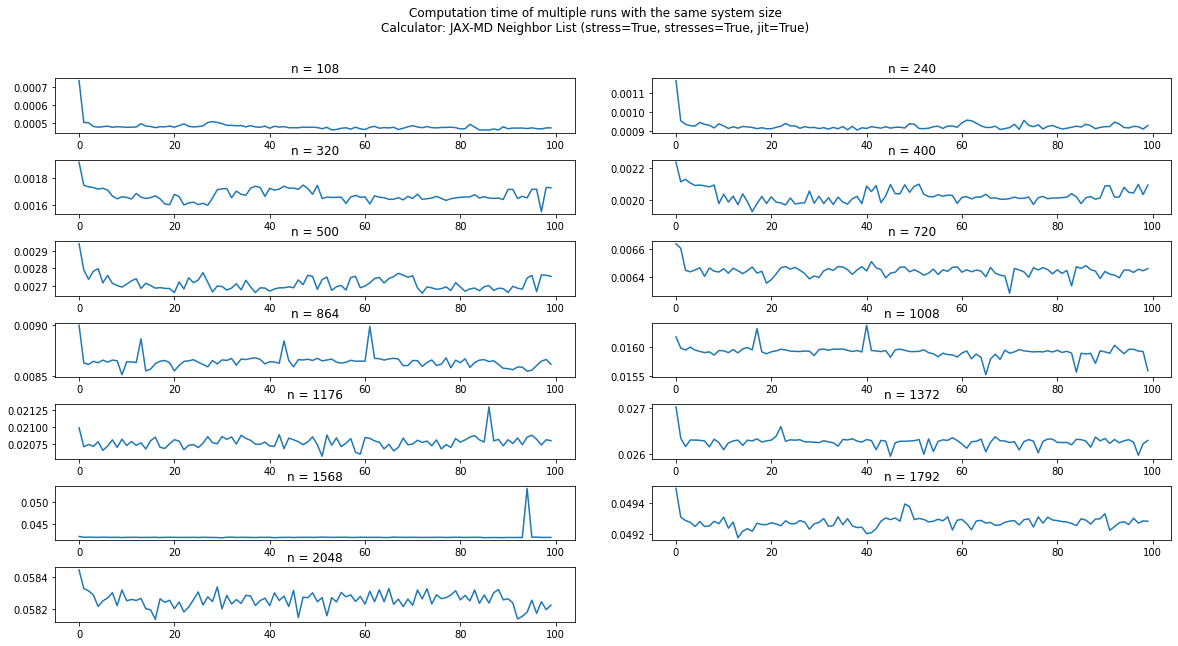

In [21]:
single_calculator = filter(lambda r: "JAX-MD Neighbor List (stress=True, stresses=True, jit=True" in r.calculator.description, results)
plot_runtime_variances(list(single_calculator))

# TODO
- Warm-up plots
- Single `JAX-MD` LJ calculator: How far can we go before we run into out-of-memory errors?
